In [1]:
import numpy as np
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import os
import ROOT
from ROOT import gSystem, gInterpreter
import approximator.particles_trajectory_generator as ptg
import approximator.runner as ap_runner
import data.bunch_configuration as buc
sns.set_style("whitegrid")
home = "/home/rafalmucha/Pobrane/optic/"
file_name = "parametrization_6500GeV_0p4_185_reco"
approximator_name = "ip5_to_station_150_h_2_lhcb1"
path_to_project = home+"/optics_generator_python"
path_to_file = home+"/2016/" + file_name + ".root"

Welcome to JupyROOT 6.16/00


In [2]:
approximator = ap_runner.get_approximator(path_to_project, path_to_file, approximator_name)

In [3]:
# Parameters of bunch
x_mean = 0.0
sigma_x = 10e-6
theta_x_mean = 0
sigma_theta_x = 10e-6
y_mean = 0.0
sigma_y = 10e-6
theta_y_mean = 0.00
sigma_theta_y = 10e-6
pt_mean = -0.01
sigma_pt = 0.001

particles_number = 1000

In [4]:
bunch_configuration = buc.BunchConfiguration.from_sigma(x_mean, sigma_x, particles_number,
                                                        theta_x_mean, sigma_theta_x, 1,
                                                        y_mean, sigma_y, 1,
                                                        theta_y_mean, sigma_theta_y, 1,
                                                        pt_mean, sigma_pt, 1)

In [5]:
output = ptg.generate_random_particles(approximator, bunch_configuration)

In [6]:
output["start"]

array([[-9.97069929e-06,  6.00666440e-06, -1.57756431e-06,
        -8.30259517e-06, -9.97270363e-03],
       [ 5.15924857e-07, -4.68946925e-06,  3.72538138e-06,
         5.90348047e-06, -1.07532716e-02],
       [-1.30397617e-06,  6.53845721e-06,  9.70743749e-06,
        -9.11490228e-06, -9.31521104e-03],
       ...,
       [-5.21361397e-06, -2.81816765e-06, -1.74929736e-06,
         2.80529307e-06, -1.07368661e-02],
       [-2.79273576e-06, -9.24931040e-06,  9.96853643e-06,
         6.48013482e-06, -1.07871133e-02],
       [-9.45508386e-06,  3.92215021e-06, -8.32875308e-06,
        -2.64291301e-06, -9.52238814e-03]])

In [7]:
# Names of segments, like MQXA.3R5
start_segment_name = "start"
end_segment_name = "end"

if start_segment_name != "start":
    output[start_segment_name].T[1] -= 1

In [8]:
output_matrix = output[end_segment_name]
input_matrix = output[start_segment_name]

In [9]:
index_map = {
    "x": 0,
    "theta x": 1,
    "y": 2,
    "theta y": 3,
    "t": 4,
    "pt": 5,
    "alfa x": 6,
    "alfa y": 7
}
meters = " [m]"
radians = " [rad]"
seconds = " [s]"
energy = " [TeV]"
no_unit = " "
unit_map = {
    "x": meters,
    "theta x": radians,
    "y": meters,
    "theta y": radians,
    "t": seconds,
    "pt": no_unit,
    "s": meters,
    "e": energy,
    "alfa x": radians,
    "alfa y": radians
}


def plot_histogram(x_name, y_name, x_name_prefix, y_name_prefix, x_matrix, y_matrix, plot_axes, plot_x_pos, plot_y_pos):
    
    title = "Histogram " + x_name_prefix + x_name + " and " + y_name_prefix + y_name + " parameter"
    
    # Get vectors and their properties
    
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    
    vector_x = pd.Series(x_matrix.T[x_index], name=x_name_prefix + x_name)
    vector_y = pd.Series(y_matrix.T[y_index], name=y_name_prefix + y_name)
    
    print(np.min(vector_x), np.max(vector_x))
    
    bins_number = 50
    
    sns.distplot(vector_x, bins=bins_number, ax=axes[plot_x_pos][plot_y_pos], color='y').set_title(title)
    sns.distplot(vector_y, bins=bins_number, ax=axes[plot_x_pos][plot_y_pos], color='b').set_title(title)

-9.995380918174981e-06 9.976216825592687e-06
-9.964611919538284e-06 9.99803385333162e-06
-9.99029069717342e-06 9.985864259611626e-06
-9.989849677007324e-06 9.930750158391337e-06


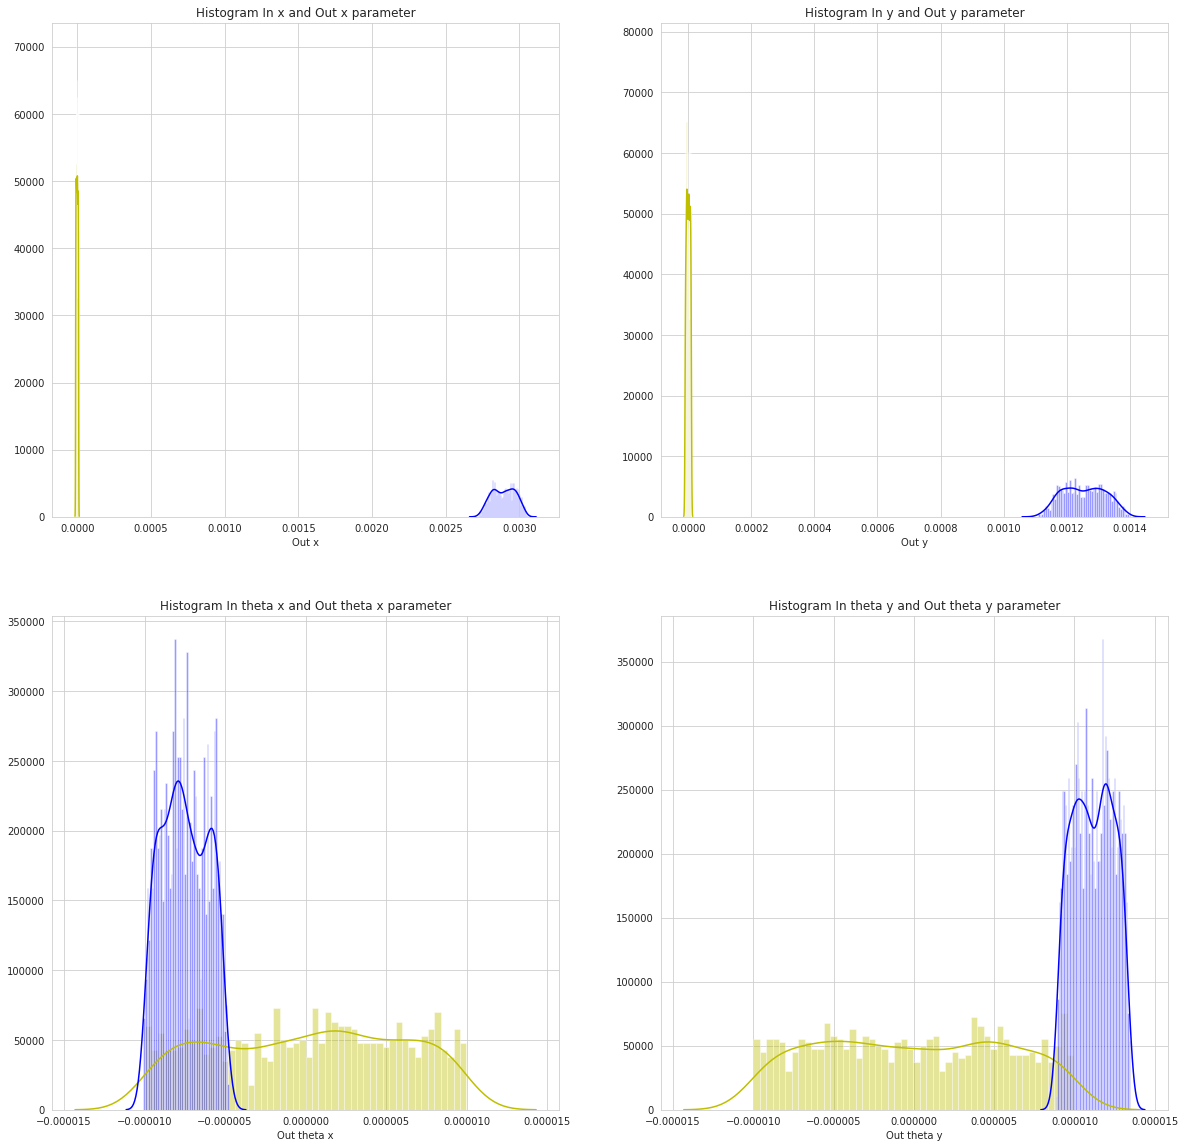

In [10]:
f, axes = plt.subplots(2, 2)

fig = plt.gcf()
fig.set_size_inches(20,20)

plot_histogram("x", "x", "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot_histogram("y", "y", "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot_histogram("theta x", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot_histogram("theta y", "theta y", "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)
